# Bootstrapping

Bootstrapping is a resampling technique for generating a distribution of datasets. For a dataset with $N$ training points, $N$ random samples are taken with replacement for each bootstrapped dataset. In this tutorial we will be training an ensemble of models, with each model trained on a bootstrapped sample of the original dataset. Applying this technique allows us to quantify uncertainty stemming from the data.

## Dataset

In [1]:
# Set a seed for reproducibility
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(0)

# Generate dataset and grid
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x, seed):
    torch.manual_seed(seed)
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values with different seeds
Y = torch.stack([target_toy(x, seed) for x, seed in zip(X, range(X.shape[0]))])

## Model

In [2]:
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
        # Additional layers can be added here based on the architecture
        # Apply Xavier uniform initialization to the weights
        self.init_weights(self.net)

    def forward(self, x):
        return self.net(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)


class PriorNet(nn.Module):
    def __init__(self, beta):
        super(PriorNet, self).__init__()
        self.prior = GenericNet(input_dim=1)  # Specify the input dimension
        self.trainable = GenericNet(input_dim=1)  # Specify the input dimension
        self.beta = beta

    def forward(self, x):
        x1 = self.prior(x)
        x2 = self.trainable(x)
        return self.beta * x1 + x2

## Training

### Ensemble

In [3]:
import push.bayes.ensemble
# Combine X and Y into a TensorDataset
dataset = TensorDataset(X, Y)

# Create a DataLoader for batch processing during training
batch_size = 100  # Adjust according to your needs
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


n=8
epochs=500
lr = 0.03

boot_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        GenericNet, 1,
        lr=lr,
        num_devices=2,
        num_ensembles=n,
        bootstrap=True
    )
    
boot_prior_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        PriorNet, 0.5,
        lr=lr,
        num_devices=2,
        num_ensembles=n,
        bootstrap=True,
        prior = True
    )

no_boot_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        GenericNet, 1,
        lr=lr,
        num_devices=2,
        num_ensembles=n,
        bootstrap=False
    )

no_boot_prior_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        PriorNet, 0.5,
        lr=lr,
        num_devices=2,
        num_ensembles=n,
        bootstrap=False,
        prior = True
    )

100%|██████████| 500/500 [00:15<00:00, 32.64it/s, loss=tensor(0.0031)]


### SWAG

In [4]:
import push.bayes.swag

pretrain_epochs = 250
swag_epochs = 250
boot_swag = push.bayes.swag.train_mswag(
    train_loader,
    torch.nn.MSELoss(),
    pretrain_epochs,
    swag_epochs,
    GenericNet, 1,
    num_devices = 2,
    num_models = n,
    lr = lr,
    bootstrap=True,
    mswag_state={}
)

boot_prior_swag = push.bayes.swag.train_mswag(
    train_loader,
    torch.nn.MSELoss(),
    pretrain_epochs,
    swag_epochs,
    PriorNet, 0.5,
    num_devices = 2,
    num_models = n,
    lr = lr,
    bootstrap=True,
    prior = True,
    mswag_state={}
)

no_boot_swag = push.bayes.swag.train_mswag(
    train_loader,
    torch.nn.MSELoss(),
    pretrain_epochs,
    swag_epochs,
    GenericNet, 1,
    num_devices = 2,
    num_models = n,
    lr = lr,
    bootstrap=False,
    mswag_state={}
)

no_boot_prior_swag = push.bayes.swag.train_mswag(
    train_loader,
    torch.nn.MSELoss(),
    pretrain_epochs,
    swag_epochs,
    PriorNet, 0.5,
    num_devices = 2,
    num_models = n,
    lr = lr,
    bootstrap=False,
    prior = True,
    mswag_state={}
)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:11<00:00, 20.93it/s, loss=tensor(0.0026)]


##### Inference


In [5]:
boot_ensemble_output = boot_ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
boot_prior_ensemble_output = boot_prior_ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
no_boot_prior_ensemble_output = no_boot_prior_ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
no_boot_ensemble_output = no_boot_ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
boot_swag_output = boot_swag.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
boot_prior_swag_output = boot_prior_swag.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
no_boot_swag_output = no_boot_swag.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
no_boot_prior_swag_output = no_boot_prior_swag.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])

##### Visualization

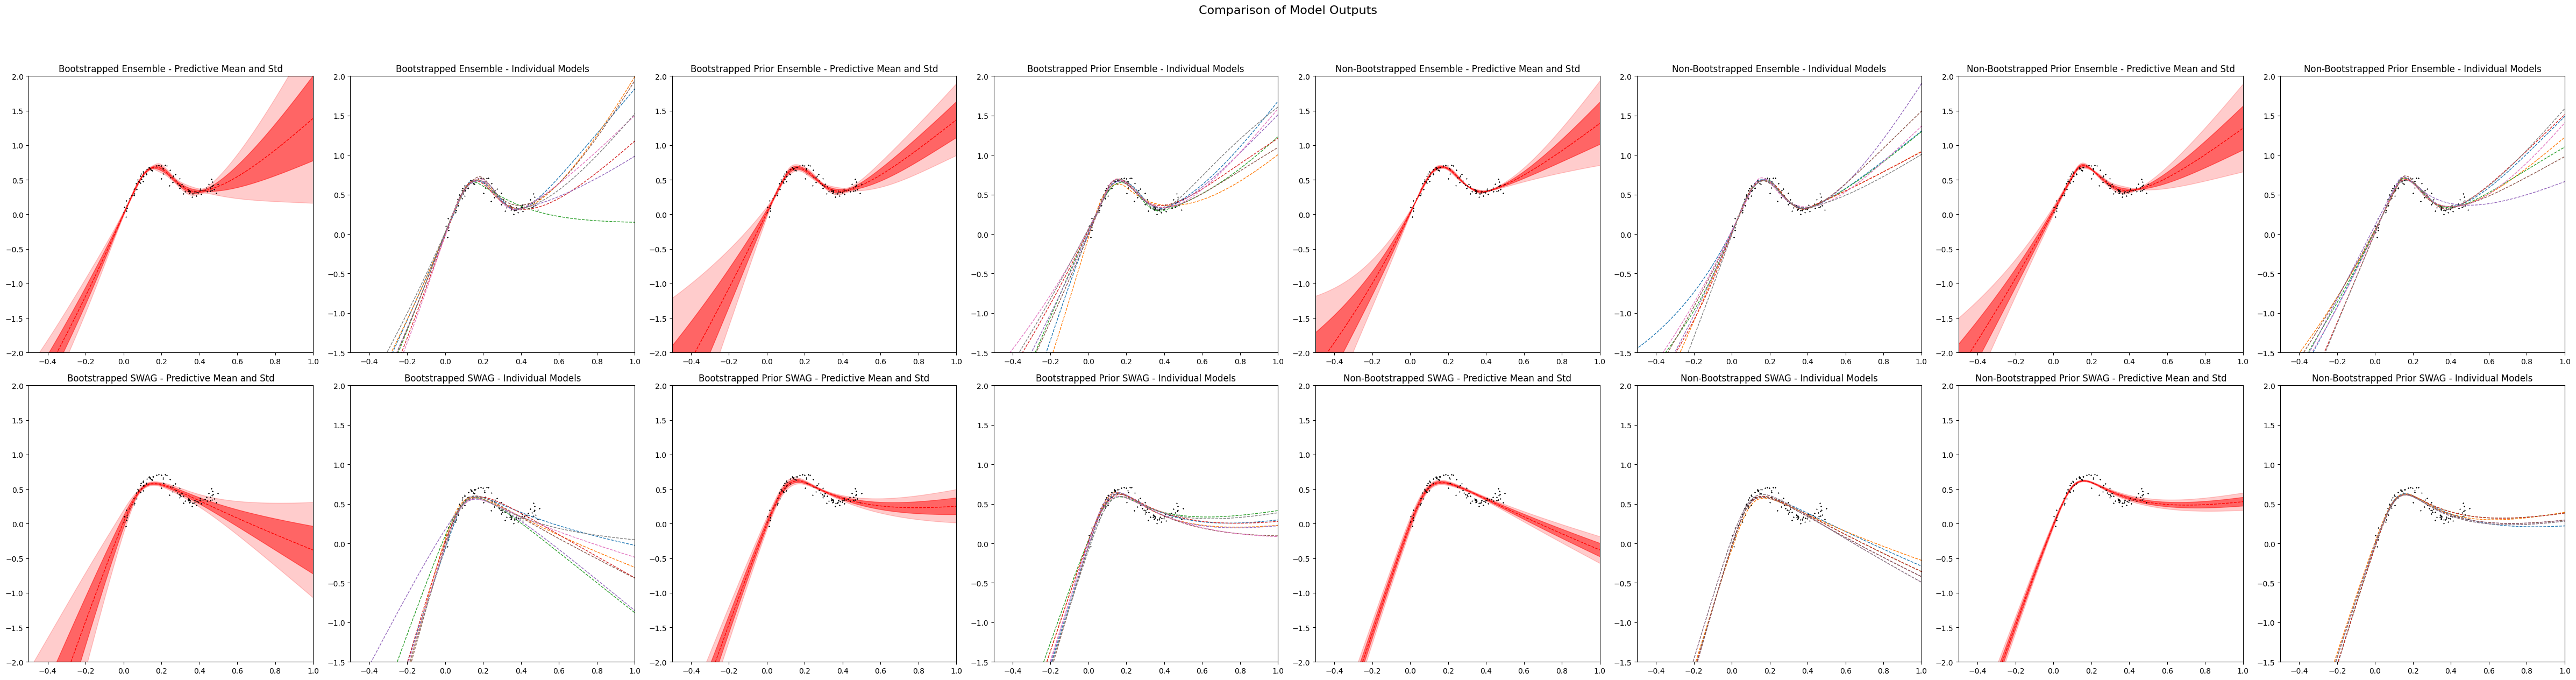

: 

In [6]:
import matplotlib.pyplot as plt
import torch

def plot_ensemble_and_individual(outputs, num_models, title, axs, col_start):
    # Ensemble outputs
    axs[col_start].plot(X, Y, "kx", label="Toy data", markersize=1)
    axs[col_start].set_xlim(-0.5, 1)
    axs[col_start].set_ylim(-2, 2)
    axs[col_start].plot(x_grid, outputs["mean"], "r--", linewidth=1)
    axs[col_start].fill_between(x_grid.reshape(1, -1)[0], (outputs["mean"] - outputs["std"]).squeeze(), (outputs["mean"] + outputs["std"]).squeeze(), alpha=0.5, color="red")
    axs[col_start].fill_between(x_grid.reshape(1, -1)[0], (outputs["mean"] + 2 * outputs["std"]).squeeze(), (outputs["mean"] - 2 * outputs["std"]).squeeze(), alpha=0.2, color="red")
    axs[col_start].set_title(f"{title} - Predictive Mean and Std")

    # Individual model outputs
    axs[col_start + 1].plot(X, Y, "kx", label="Toy data", markersize=1)
    axs[col_start + 1].set_xlim(-0.5, 1)
    axs[col_start + 1].set_ylim(-1.5, 2)
    for j in range(num_models):
        axs[col_start + 1].plot(x_grid, torch.tensor([sublist[j] for sublist in outputs["pred"]]), linestyle="--", linewidth=1)
    axs[col_start + 1].set_title(f"{title} - Individual Models")

def plot_all():
    fig, axs = plt.subplots(nrows=2, ncols=8, figsize=[48, 12])  # Adjust dimensions as needed

    # Plot bootstrapped and non-bootstrapped ensemble and individual models in one row
    plot_ensemble_and_individual(boot_ensemble_output, n, "Bootstrapped Ensemble", axs[0, :], 0)
    plot_ensemble_and_individual(boot_prior_ensemble_output, n, "Bootstrapped Prior Ensemble", axs[0, :], 2)
    plot_ensemble_and_individual(no_boot_ensemble_output, n, "Non-Bootstrapped Ensemble", axs[0, :], 4)
    plot_ensemble_and_individual(no_boot_prior_ensemble_output, n, "Non-Bootstrapped Prior Ensemble", axs[0, :], 6)

    # Plot SWAG models in another row
    plot_ensemble_and_individual(boot_swag_output, n, "Bootstrapped SWAG", axs[1, :], 0)
    plot_ensemble_and_individual(boot_prior_swag_output, n, "Bootstrapped Prior SWAG", axs[1, :], 2)
    plot_ensemble_and_individual(no_boot_swag_output, n, "Non-Bootstrapped SWAG", axs[1, :], 4)
    plot_ensemble_and_individual(no_boot_prior_swag_output, n, "Non-Bootstrapped Prior SWAG", axs[1, :], 6)

    # Set overall title and adjust layout
    fig.suptitle('Comparison of Model Outputs', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# Call this function to generate all plots
plot_all()


[1] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.
